# Neural networks with PyTorch

I will build a larger network that can identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

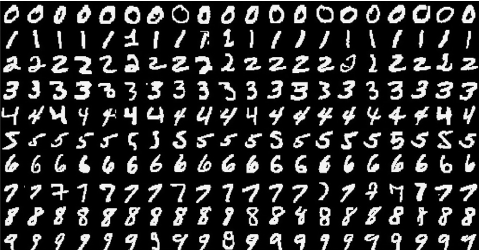

My goal is to build a neural network that can take one of these images and predict the digit in the image.

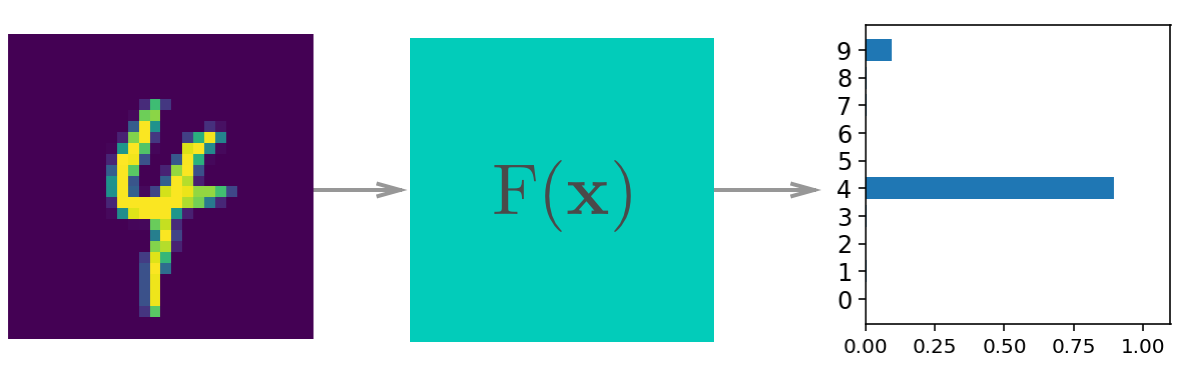

## Import Resources

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Load the Data

In [3]:
# Pipline of transformation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


## Visualize a Batch of Training Data

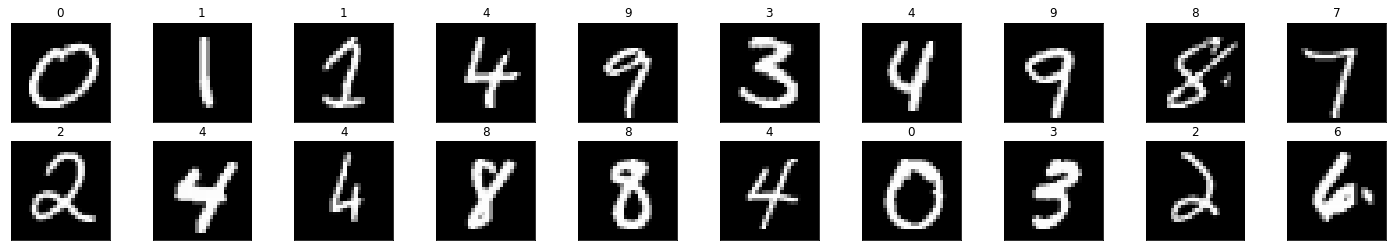

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

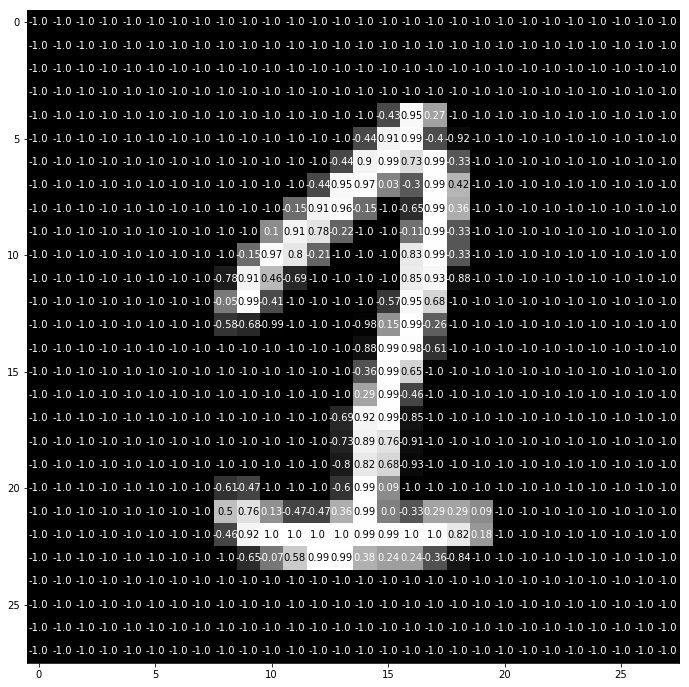

In [9]:
img = np.squeeze(images[2])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

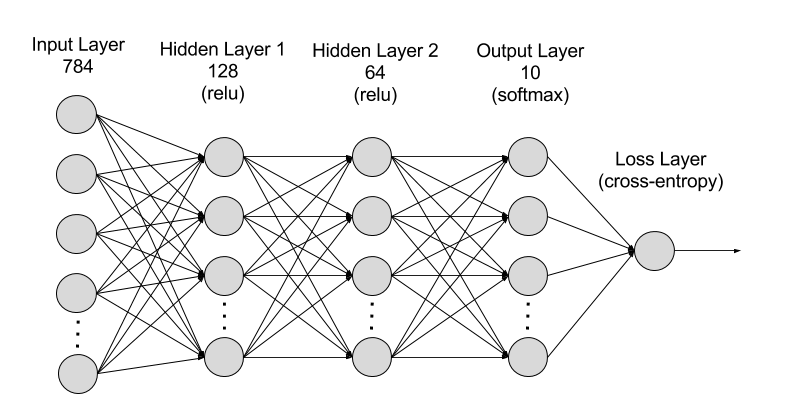

### Method1: Using `nn.Model` superclass

In [15]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()

### Method2:Using `nn.Sequential`

In [16]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

## Specifiy the Loss function and Optimizer

In [17]:
from torch import optim
# Create the network, define the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train the Model

The steps for training/learning from a batch of data are described in the comments below:

* Clear the gradients of all optimized variables
* Forward pass: compute predicted outputs by passing inputs to the model
* Use the logits to calculate the loss
* Backward pass: compute gradient of the loss with respect to model parameters
* Perform a single optimization step (parameter update)



In [18]:
# Train the network here
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # # flatten image input
        images = images.view(images.shape[0], -1) # image = image.view(-1, 28 * 28)
    
        # Training pass
        optimizer.zero_grad()
        
        ## Forward
        output = model.forward(images)
        
        ## Backward
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.053575933170217
Training loss: 0.3961105058188123
Training loss: 0.33139753491004137
Training loss: 0.2971121831727562
Training loss: 0.2710466879898551


## Test the Model

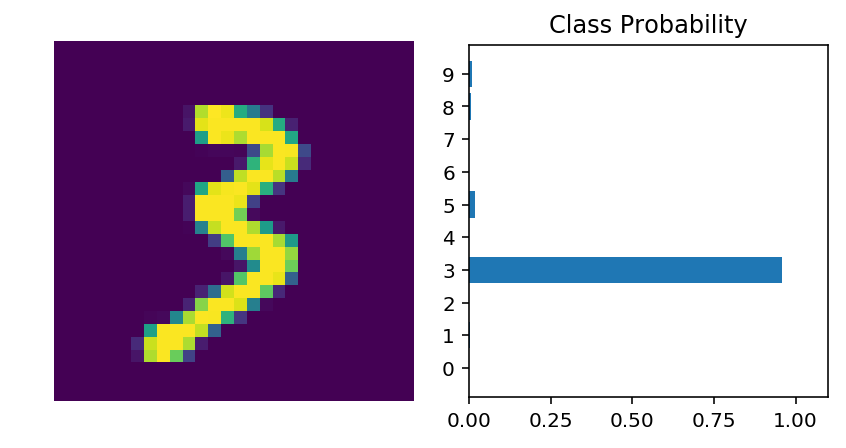

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

images, labels = next(iter(testloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)